In [9]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from HROCH import Xicor
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

In [10]:
# Step 3: Load and explore data
df_train = pd.read_csv("../molecular-machine-learning/data/train.csv")
df_test = pd.read_csv("../molecular-machine-learning/data/test.csv")
submission = pd.read_csv("../molecular-machine-learning/data/sample_submission.csv")

In [11]:
# Display dataset summary
print(f"The dataset contains {df_train.shape[0]} rows and {df_train.shape[1]} columns.")
print("Summary of columns:")
print(f"- Total columns: {df_train.shape[1]}")
print(f"- Numerical columns: {df_train.select_dtypes(include=['int64', 'float64']).shape[1]}")
print(f"- Categorical columns: {df_train.select_dtypes(include=['object', 'category']).shape[1]}")
print(f"- Boolean columns: {df_train.select_dtypes(include=['bool']).shape[1]}")
print(f"- Columns with missing values: {df_train.isnull().sum().loc[df_train.isnull().sum() > 0].shape[0]}")
print("\nMissing values in the dataset:")
print(df_train.isnull().sum().sum())

The dataset contains 42 rows and 146 columns.
Summary of columns:
- Total columns: 146
- Numerical columns: 144
- Categorical columns: 2
- Boolean columns: 0
- Columns with missing values: 0

Missing values in the dataset:
0


In [12]:
# Step 4: Preprocess data
# Impute missing values with median for numerical columns
for column in df_train.select_dtypes(include=[np.number]).columns:
    if df_train[column].isnull().any():
        df_train[column].fillna(df_train[column].median(), inplace=True)
        df_test[column].fillna(df_train[column].median(), inplace=True)

In [13]:

# Cap outliers for key features
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = data[column].clip(lower_bound, upper_bound)
    return data

key_features = ['T80', 'Mass', 'NumHeteroatoms', 'TDOS4.0']
for feature in key_features:
    if feature in df_train.columns:
        df_train = cap_outliers(df_train, feature)
        if feature != 'T80':  # Don't cap T80 in test set
            df_test = cap_outliers(df_test, feature)

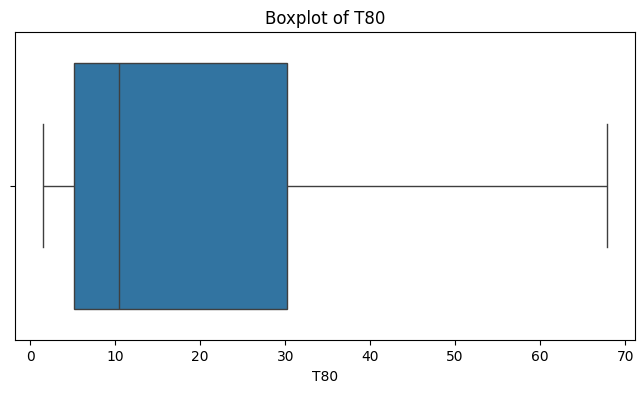

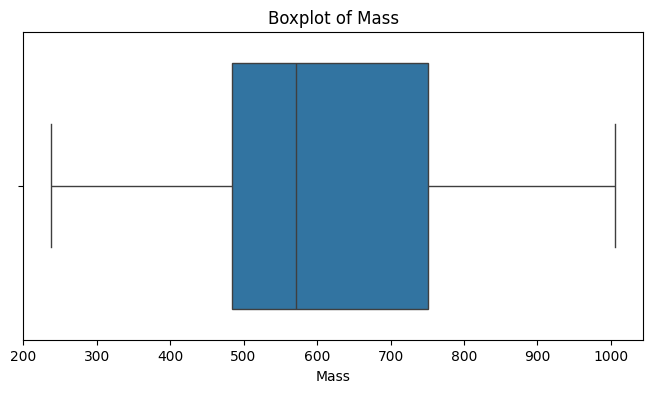

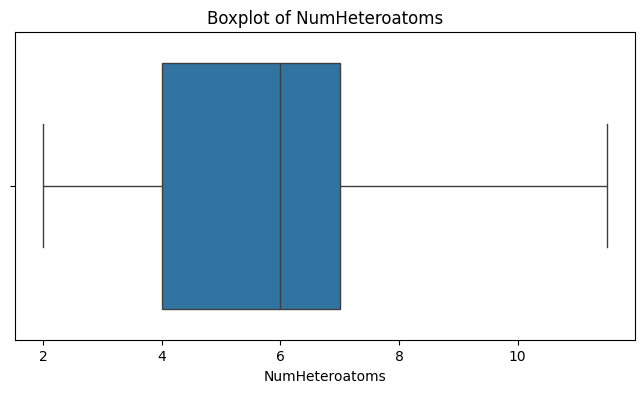

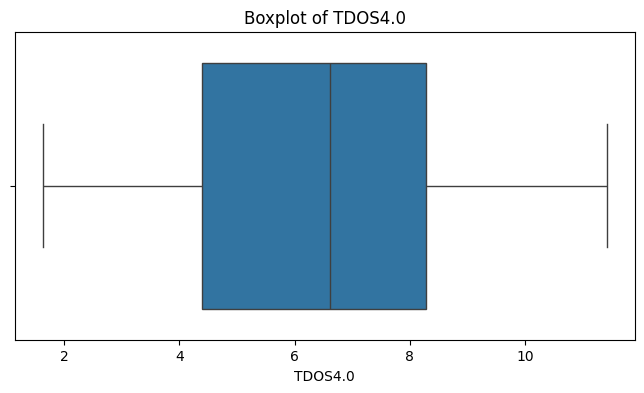

In [14]:
# Visualize outliers
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_train[feature])
    plt.title(f"Boxplot of {feature}")
    plt.show()

In [15]:
# Step 5: RDKit feature engineering
# Compute RDKit descriptors
def compute_rdkit_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return pd.Series({
            'MolWt': Descriptors.MolWt(mol),
            'MolLogP': Descriptors.MolLogP(mol),
            'NumValenceElectrons': Descriptors.NumValenceElectrons(mol),
            'TPSA': Descriptors.TPSA(mol)
        })
    except:
        return None

In [16]:

df_train_rdkit = df_train['Smiles'].apply(compute_rdkit_features)
df_test_rdkit = df_test['Smiles'].apply(compute_rdkit_features)

In [17]:
# Remove invalid SMILES
df_train = df_train.loc[~df_train_rdkit.isna().any(axis=1)]
df_test = df_test.loc[~df_test_rdkit.isna().any(axis=1)]
df_train = pd.concat([df_train, df_train_rdkit], axis=1)
df_test = pd.concat([df_test, df_test_rdkit], axis=1)

In [18]:
# Compute Morgan fingerprints
def smiles_to_morgan_bits(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return np.array([int(x) for x in fp])


In [19]:
train_morgan = np.array([smiles_to_morgan_bits(smiles) for smiles in df_train['Smiles']])
test_morgan = np.array([smiles_to_morgan_bits(smiles) for smiles in df_test['Smiles']])
morgan_columns = [f'frag_{i}' for i in range(train_morgan.shape[1])]
df_train_morgan = pd.DataFrame(train_morgan, columns=morgan_columns, index=df_train.index)
df_test_morgan = pd.DataFrame(test_morgan, columns=morgan_columns, index=df_test.index)
df_train = pd.concat([df_train, df_train_morgan], axis=1)
df_test = pd.concat([df_test, df_test_morgan], axis=1)

In [20]:
# Step 6: Feature selection
# Remove highly correlated features
numerical_columns = df_train.select_dtypes(include=[np.number]).columns.drop('T80')
corr_matrix = df_train[numerical_columns].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
df_train = df_train.drop(columns=to_drop, errors='ignore')
df_test = df_test.drop(columns=to_drop, errors='ignore')

In [21]:
# Xicor feature selection
numerical_columns = [col for col in df_train.select_dtypes(include=[np.number]).columns if col != 'T80']
frag_columns = [col for col in df_train.columns if col.startswith('frag_')]
corel_num = sorted([(c, Xicor(df_train[c].values, df_train['T80'].values)) for c in numerical_columns], key=lambda x: x[1], reverse=True)
corel_frag = sorted([(c, Xicor(df_train[c].values, df_train['T80'].values)) for c in frag_columns], key=lambda x: x[1], reverse=True)
top_num_features = [c for c, _ in corel_num[:30]]
top_frag_features = [c for c, _ in corel_frag[:100]]
selected_features = top_num_features + top_frag_features

In [22]:
# Ensure key features are included
key_features = ['TDOS4.0', 'NumHeteroatoms', 'Mass']
selected_features = list(set(selected_features + key_features).intersection(df_train.columns))
X_train = df_train[selected_features]
X_test = df_test[selected_features]
y_train = df_train['T80']

In [23]:
# Step 7: Data scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Step 8: Model selection and tuning
models = {
    'SVR': SVR(),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'LASSO': Lasso(random_state=42)
}

In [25]:
# Evaluate models with cross-validation
print("\nModel performance (RMSE):")
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    print(f"{name}: {rmse:.4f} ± {np.sqrt(scores.std()):.4f}")


Model performance (RMSE):
SVR: 24.4873 ± 31.5354
RandomForest: 26.7242 ± 29.4299
XGBoost: 30.0774 ± 32.1236
LASSO: 26.2469 ± 29.2191


In [26]:
# Hyperparameter tuning for SVR
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("\nBest SVR parameters:", grid_search.best_params_)
print("Best SVR RMSE:", np.sqrt(-grid_search.best_score_))


Best SVR parameters: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}
Best SVR RMSE: 23.893760508215063


In [27]:
# Step 9: Ensemble predictions
svr = SVR(**grid_search.best_params_).fit(X_train_scaled, y_train)
rf = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train_scaled, y_train)
xgb = XGBRegressor(random_state=42, n_jobs=-1).fit(X_train_scaled, y_train)

In [28]:
# Predict on test set
y_pred_svr = svr.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)
y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_ensemble = 0.5 * y_pred_svr + 0.3 * y_pred_rf + 0.2 * y_pred_xgb
y_pred_ensemble = np.clip(y_pred_ensemble, 0, 1000)

In [29]:
# Compute ensemble RMSE via cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
for train_idx, val_idx in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    svr.fit(X_tr, y_tr)
    rf.fit(X_tr, y_tr)
    xgb.fit(X_tr, y_tr)
    y_pred_svr_val = svr.predict(X_val)
    y_pred_rf_val = rf.predict(X_val)
    y_pred_xgb_val = xgb.predict(X_val)
    y_pred_ensemble_val = 0.5 * y_pred_svr_val + 0.3 * y_pred_rf_val + 0.2 * y_pred_xgb_val
    y_pred_ensemble_val = np.clip(y_pred_ensemble_val, 0, 1000)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_ensemble_val))
    rmse_scores.append(rmse)

print(f"\nEnsemble RMSE (cross-validation): {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")


Ensemble RMSE (cross-validation): 17.0642 ± 5.3716


In [1]:
# # Step 10: Generate submission
# submission = pd.DataFrame({'Batch_ID': df_test['Batch_ID'], 'T80': y_pred_ensemble})
# submission.to_csv('submission2.csv', index=False)
# print("\nSubmission saved to submission.csv")